In [7]:
#Data processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from nptdms import TdmsFile #Process raw ramping file


Bad key "text.kerning_factor" on line 4 in
/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# 1. Sample functions

**Note:**
- I sometimes refer to a sensor's data by channel.


- The `sample-data` directory is a segment of Ramp28 data in range (-10,0). With 0 being the time when the quench protection system kicks in and current starts dropping. 


- It has several `.npy` files. `ai0-ai4.npy` corresponds to 5 sensors around the magnet. `ai7.npy` is the current data. `time.npy` is the time relative to the quench of each data point in those files. 

In [34]:
#Loading data function
def load_channel_and_time(dir_path, channel):
    """Loading a channel from a directory and return a pandas data frame with two columns, channle and time"""
    
    data_frame = pd.DataFrame(data = {channel: np.load(dir_path + channel + ".npy"),
                                     "time": np.load(dir_path + "time.npy")})
    
    return data_frame


#Plot a single channel, used by next function
def plot_channel(data, channel, time_range = None):
    
    #Take data within the time range
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    #plot
    plt.figure(figsize=(20,2))
    plt.plot(data["time"], data[channel])
    plt.xlabel("Time (s)")
    plt.ylabel("Volt")
    plt.title("Variable {}".format(channel))
    plt.show()
    
    %reset -f in

#Plotting data function
def load_and_plot(dir_path, channel, time_range = None):
    """Load a particular channel from a quench, and then plot it.  
    """
    ai = load_channel_and_time(dir_path, channel)
    
    plot_channel(ai, channel, time_range = time_range)
    
    #Just for dumping data from RAM on the server, needed when processing larger amount of data
    #don't need to worry about this for now. 
    %reset -f in
    
#Spectrogram plotting function
def plot_spectrogram(dir_path, channel, time_range, window = 1500, step = 10, window_type = 'hanning'):
    
    #Select appropriate time segment
    data = load_channel_and_time(dir_path, channel)

    start = time_range[0]
    end = time_range[1]

    data = data[(data["time"] > start) & (data["time"] < end)]


    from scipy import signal
    
    #FFT
    freqs, times, Sx = signal.spectrogram(data[channel], fs=100000, window= window_type,
                                      nperseg=window, noverlap= window - step,
                                      detrend=False, scaling='spectrum')
    
    #Dump data from RAM
    %reset -f in
    
    #Plot!
    f, ax = plt.subplots(figsize=(20,2))
    ax.pcolormesh(times, freqs / 1000, 10 * np.log10(Sx), cmap='viridis')
    ax.set_title("Spectrogram of sensor {}".format(channel))
    ax.set_ylabel('Frequency [kHz]')
    ax.set_xlabel('Time [s]');

#########-------Zero crossings---------###########
def zero_crossings(array):
    
    zero_crossings = ((array[:-1] * array[1:]) < 0).sum()
    
    return zero_crossings

def calculate_zero_crossings(dir_path, channel, time_range = None):
    """Calculate the number of zero-crossings for a particular time segmetn in acoustic data"""
    data = load_channel_and_time(dir_path, channel)
    
    #Take data within the time range
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    %reset -f in
    
    return zero_crossings(data[channel].to_numpy())

def plot_zero_crossings(dir_path, channel, time_range = None, window = 2000):
    
    data = load_channel_and_time(dir_path, channel)
    
    #Take data within the time range
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    #Zero-crossings
    plt.figure(figsize=(20,2))
    plt.plot(data["time"], data.loc[:, channel].rolling(window=window).apply(zero_crossings, raw = True),
             label = "Number of zero-crossings",
             color = 'orange')
    plt.xlabel("Time (s)")
    plt.title("Variable {}'s Zero crossings".format(channel))
    plt.show()
    
    %reset -f in

#########-------RMS values---------###########
def rms(data):
    return np.nanmean(np.sqrt(data**2))

def load_sensor(dir_path, sensor, time_range = None):
    
    data = pd.DataFrame(data = {sensor: np.load(dir_path + sensor + ".npy"),
                                "time": np.load(dir_path + "time.npy")})
    
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    data = data[(data["time"] > start) & (data["time"] < end)]
   
    %reset -f in
    
    return data[sensor]

def load_time(dir_path, time_range = None):
    
    tdata = np.load(dir_path + "time.npy")
    
    start = min(tdata)
    end = max(tdata)
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    tdata = tdata[(tdata > start) & (tdata < end)]
   
    %reset -f in
    
    return tdata

def plot_rms(dir_path, channel, time_range = None, window = 2000, step = 10):
    
    time_axis = load_time(dir_path, time_range)[window-1::step]
    rms_sensor = load_sensor(dir_path, channel, time_range = time_range).rolling(window=window).apply(rms, raw = True).to_numpy()[window-1::step]
    
    #Variance
    plt.figure(figsize=(20,2))
    plt.plot(time_axis, 
             rms_sensor,
             label = "Moving RMS",
             color = 'orange')
    plt.xlabel("Time (s)")
    plt.title("Variable {}'s Moving RMS".format(channel))
    plt.show()
    
#########-------Wavelet analysis---------###########
import pywt

def filter_bank(dir_path, sensor, time_range):

    #Load time and data
    chirp_signal = load_sensor(dir_path, sensor, time_range)
    x = np.linspace(0, 1, num=len(chirp_signal))

    fig, ax = plt.subplots(figsize=(6,1))
    ax.set_title("Original Signal")
    ax.plot(chirp_signal)
    plt.show()

    data = chirp_signal
    waveletname = 'sym5'

    #Initialize plot grid
    fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6,6))

    #Wavelet transform for different levels
    for ii in range(5):

        #Obtain approximation coefficients and detail coefficients
        (data, coeff_d) = pywt.dwt(data, waveletname)
        axarr[ii, 0].plot(data, 'r')
        axarr[ii, 1].plot(coeff_d, 'g')


        axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
        axarr[ii, 0].set_yticklabels([])

        #Set label for first set of plot
        if ii == 0:
            axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
            axarr[ii, 1].set_title("Detail coefficients", fontsize=14)

        axarr[ii, 1].set_yticklabels([])

    #Additional formatting
    plt.tight_layout()
    plt.show()

## 2. Sample usage

### 2.1 Plot an particular event from Ramp28 that DNN detected

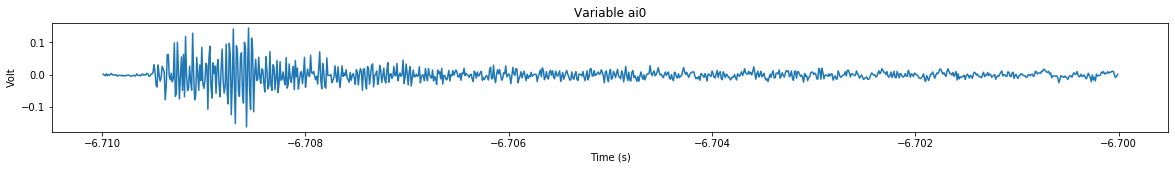

Flushing input history
Flushing input history


In [31]:
load_and_plot("./sample-data/Ramp28/", "ai0", time_range = (-6.710, -6.70))

### 2.2 Plot its spectrogram

Flushing input history


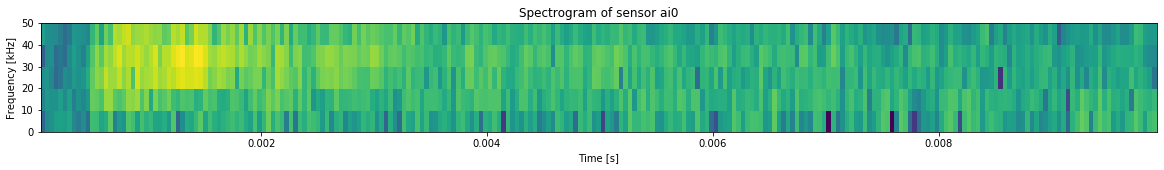

In [32]:
plot_spectrogram("./sample-data/Ramp28/", "ai0", time_range = (-6.710, -6.70), window = 10, step = 4)

### 2.3 Plot & calculate zero-zrossings

In [35]:
#Calculate zero-crossings for a particular segment
calculate_zero_crossings("./sample-data/Ramp4/", "ai2", time_range = (-2.1525, -2.1525 + 1.5e-3))

Flushing input history


64

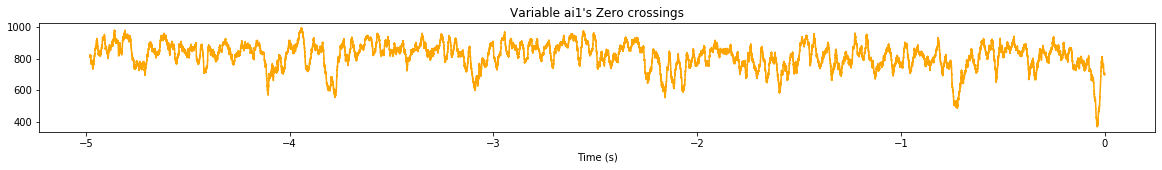

Flushing input history


In [36]:
#Plot moving zero-crossings
plot_zero_crossings("./sample-data/Ramp4/", "ai1", time_range = (-5, 0), window = 2000)

### 2.4 Plot RMS values

Flushing input history
Flushing input history


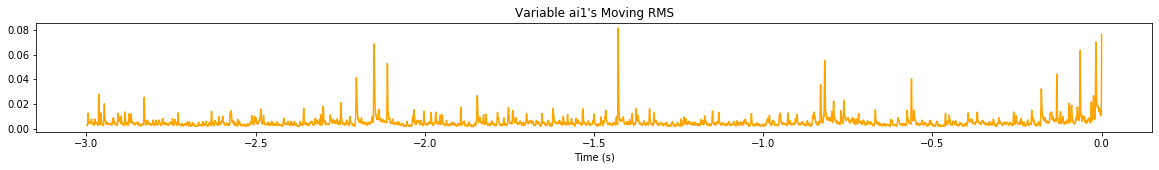

In [37]:
plot_rms("./sample-data/Ramp4/", "ai1", time_range = (-3, 0), window = 200, step = 10)

### 2.5 Wavelet analysis

**Note:** Code is based on this: http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/ 

Flushing input history


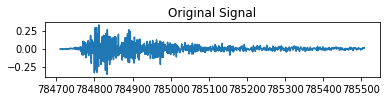

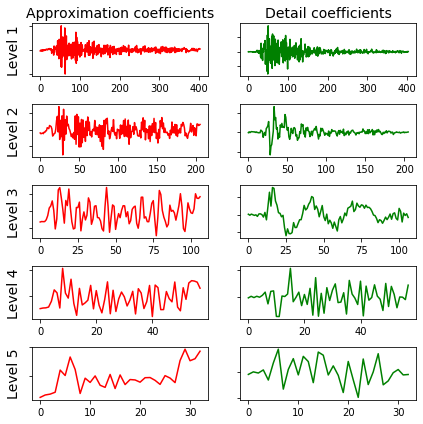

In [38]:
filter_bank("./sample-data/Ramp4/", "ai0", time_range = (-2.1529, -2.1529 + 8e-3))